In [1]:
import numpy as np
import pandas as pd
import seaborn; seaborn.set()
from pmdarima import auto_arima
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib.pylab as plt

In [2]:
XRPoct_df = pd.read_csv('../../Resources/XRP/XRP-USD_Historical_Oct-2021.csv',index_col='Date', parse_dates= True)
XRPoct_df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,0.006523,0.007160,0.006031,0.006314,0.006314,3.915676e+07
2017-02-01,0.006311,0.007833,0.005427,0.005536,0.005536,2.363711e+07
2017-03-01,0.005525,0.021776,0.005372,0.020889,0.020889,2.205734e+08
2017-04-01,0.021743,0.071441,0.019664,0.051607,0.051607,1.109644e+09
2017-05-01,0.051580,0.435170,0.049317,0.246590,0.246590,5.788513e+09


In [3]:
XRPoct_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [4]:
XRPoct_df = XRPoct_df.drop(columns=['Open','High','Low','Adj Close','Volume'])

In [5]:
XRPoct_df.head(10)

,Close
Date,
2017-01-01,0.006314
2017-02-01,0.005536
2017-03-01,0.020889
2017-04-01,0.051607
2017-05-01,0.246590
2017-06-01,0.262930
2017-07-01,0.167386
2017-08-01,0.255630
2017-09-01,0.197529


In [6]:
XRPoct_df.dtypes

Close    float64
dtype: object

In [7]:
#help(seasonal_decompose)

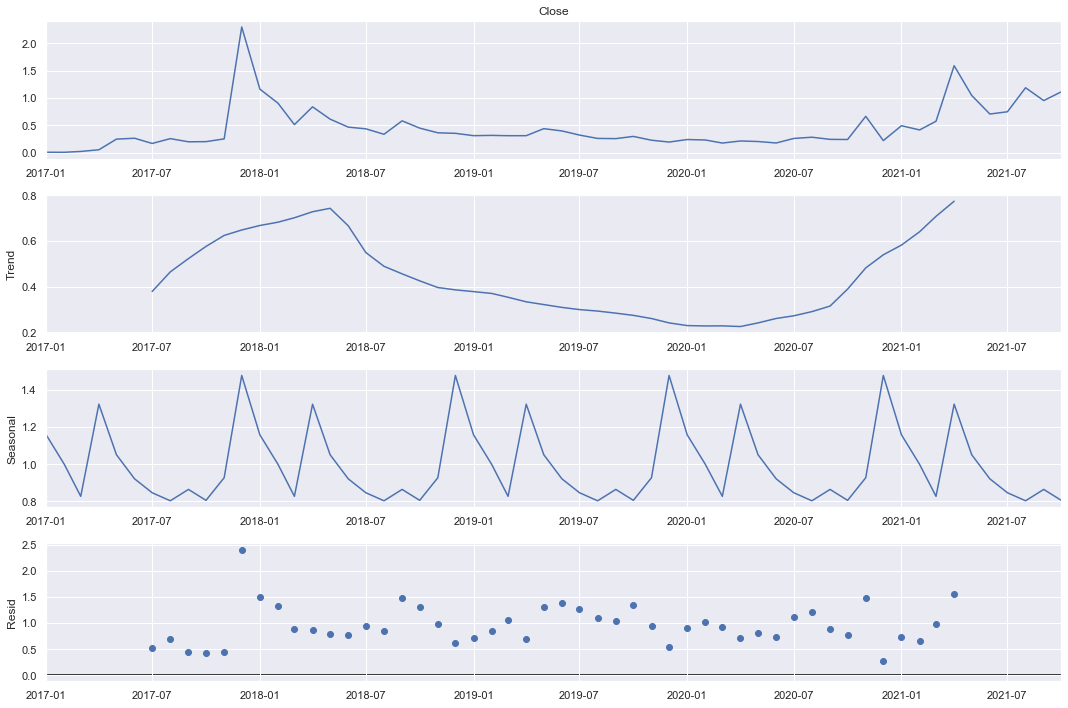

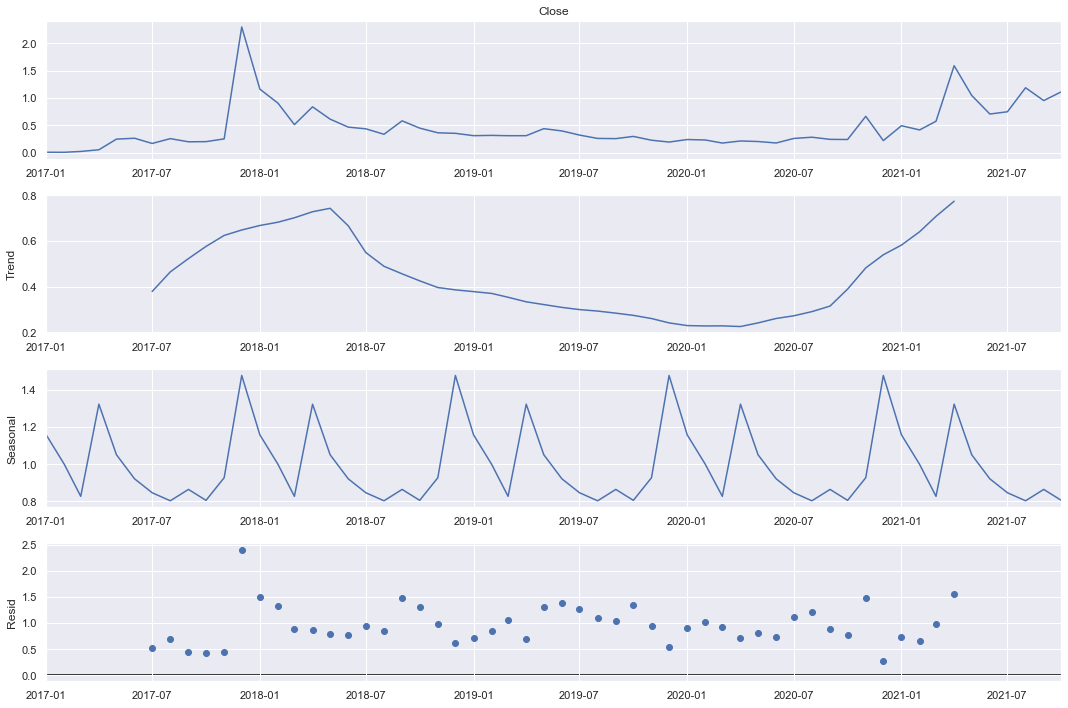

In [8]:
results = seasonal_decompose(XRPoct_df['Close'],model ='multiplicative',period=12)
plt.rcParams.update({'figure.figsize': (15,10)})
results.plot()

In [9]:
#Arima
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function to XRP dataset
stepwise_fit = auto_arima(XRPoct_df['Close'], start_p = 0, start_q = 0,
max_p = 4, max_q = 4, m = 12,
start_P = 0, seasonal = True,
d = None, D = 1, trace = True,
error_action ='ignore', # we don't want to know if an order does not work
suppress_warnings = True, # we don't want convergence warnings
stepwise = True)# set to stepwise

# To print the summary
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=79.824, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=56.541, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=65.938, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=80.123, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=55.412, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=56.637, Time=0.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=58.540, Time=0.11 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=56.135, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=55.759, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=66.631, Time=0.02 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=57.520, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=54.545, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12]             : AIC=55.537, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[12]             : AIC=55.729,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   58
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 -25.272
Date:                            Mon, 13 Dec 2021   AIC                             54.545
Time:                                    01:06:44   BIC                             58.202
Sample:                                         0   HQIC                            55.915
                                             - 58                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7124      0.118      6.057      0.000       0.482       0.943
sigma2         0.1730      0.014     12.169      0.000       0.145       0.201
===================================================================================
Ljung-Box (L1) (Q):                   1.24   Jarque-Bera (JB):               309.34
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -2.13
Prob(H) (two-sided):                  0.08   Kurtosis:                        14.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# Split data into train / test sets
train = XRPoct_df.iloc[:len(XRPoct_df)-12]
test = XRPoct_df.iloc[len(XRPoct_df)-12:] # set one year(12 months) for testing

# Fit a SARIMAX(1, 0, 0)x(0, 1, 0, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Close'],
order = (1, 0, 0),
seasonal_order =(0, 1, 0, 12))

result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                   46
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 -18.455
Date:                            Mon, 13 Dec 2021   AIC                             40.910
Time:                                    01:06:44   BIC                             43.963
Sample:                                01-01-2017   HQIC                            41.951
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6257      0.161      3.887      0.000       0.310       0.941
sigma2         0.1709      0.014     11.785      0.000       0.142       0.199
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):               323.04
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -2.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

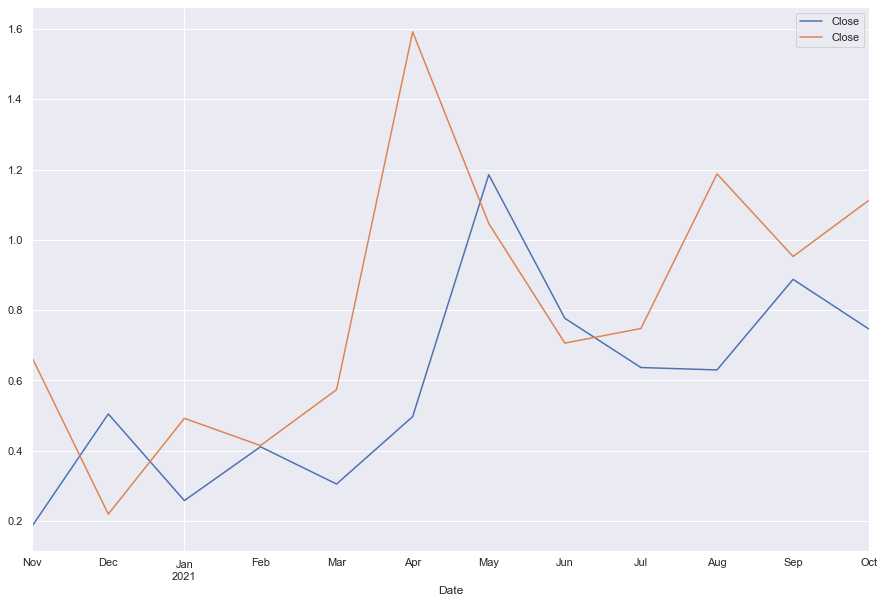

In [15]:
#Predictions of ARIMA Model agains the Test set
start = len(train)
end = len(train) + len(test) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end,typ = 'levels').rename("Close")

# plot predictions and actual values
predictions.plot(legend = True)
test['Close'].plot(legend = True)

In [16]:
#Evaluate the model using MSE and RMSE
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
rmse(test["Close"], predictions)

0.42042714949547516

In [17]:
# Calculate mean squared error
mean_squared_error(test["Close"], predictions)

0.1767589880328906

Text(0, 0.5, 'Closing Amount (USD)')

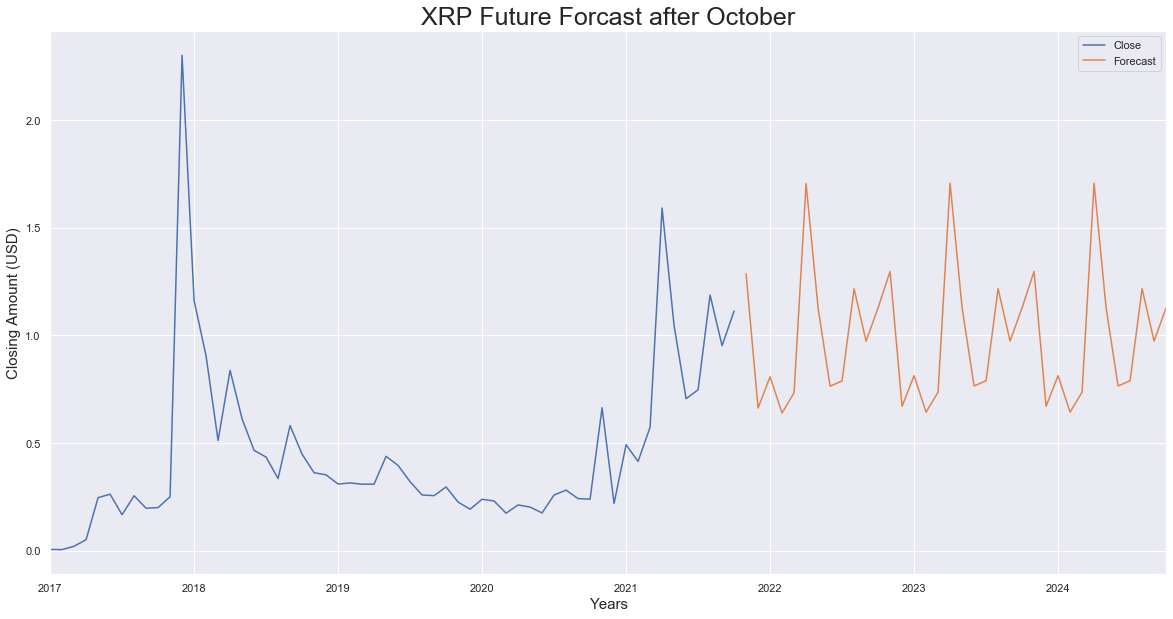

In [18]:
# Train the model on the full dataset
model = model = SARIMAX(XRPoct_df['Close'],order = (1, 0, 0),seasonal_order =(0, 1, 0, 12))
result = model.fit()

# Forecast for the next 3 years
forecast = result.predict(start = len(XRPoct_df),end = (len(XRPoct_df)-1) + 3 * 12,typ = 'levels').rename('Forecast')

# Plot the forecast values
XRPoct_df['Close'].plot(figsize = (20, 10), legend = True)
forecast.plot(legend = True)
plt.title("XRP Future Forcast after October", fontsize = 25)
plt.xlabel('Years',fontsize=15)
plt.ylabel('Closing Amount (USD)',fontsize=15)